In [16]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [17]:
# seeding 
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
np.random.seed(42)
rn.seed = 42
tf.random.set_seed(42)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [18]:
%%capture
!pip install huggingface-hub
!pip install gradio

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [20]:
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
# load dataset CIFAR 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [22]:
# hyperParams
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [23]:
# resize the image and it to a float between 0,1
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [36]:
# package it into tensorflow dataset
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [37]:
# the cutmix procedure
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


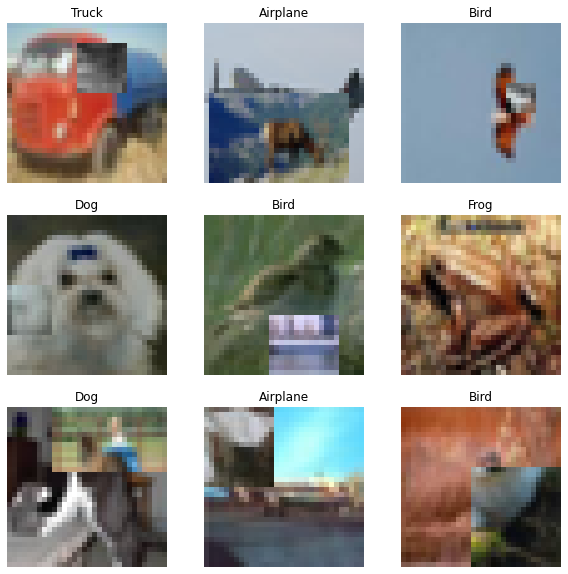

In [42]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [24]:
# from keras.preprocessing.image import save_img

# image_batch, label_batch = next(iter(train_ds_simple))

# save_img('./content/examples/' + class_names[np.argmax(label_batch[0])] + '.jpeg', image_batch[0])
# save_img('./content/examples/' + class_names[np.argmax(label_batch[1])] + '.jpeg', image_batch[1])

In [26]:
# resnet 20 model
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [27]:
# train with cutmix data
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds_cmu, validation_data=test_ds, epochs=20, callbacks = [tensorboard_callback])

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/20
1563/1563 [==============================] - 60s 28ms/step - loss: 1.9318 - accuracy: 0.4017 - val_loss: 1.4540 - val_accuracy: 0.5320
Epoch 2/20
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6748 - accuracy: 0.5243 - val_loss: 1.3759 - val_accuracy: 0.5746
Epoch 3/20
1563/1563 [==============================] - 32s 21ms/step - loss: 1.5634 - accuracy: 0.5811 - val_loss: 1.3182 - val_accuracy: 0.5903
Epoch 4/20
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4940 - accuracy: 0.6131 - val_loss: 0.9959 - val_accuracy: 0.7151
Epoch 5/20
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4484 - accuracy: 0.6349 - val_loss: 1.0150 - val_accuracy: 0.6995
Epoch 6/20
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4211 - accuracy: 0.6447 - val_loss: 1.0619 - val_accuracy: 0.6893
Epoch 7/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3943 - accuracy: 0.6619 - val_loss: 1.0144 -

In [28]:
# train with normal data
model2 = training_model()
model2.load_weights("initial_weights.h5")
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.fit(train_ds_simple, validation_data=test_ds, epochs=20)

test_loss, test_accuracy = model2.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/20
1563/1563 [==============================] - 25s 15ms/step - loss: 1.4817 - accuracy: 0.5200 - val_loss: 1.4026 - val_accuracy: 0.5590
Epoch 2/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0719 - accuracy: 0.6759 - val_loss: 1.1147 - val_accuracy: 0.6661
Epoch 3/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9010 - accuracy: 0.7420 - val_loss: 1.0818 - val_accuracy: 0.6836
Epoch 4/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.7935 - accuracy: 0.7827 - val_loss: 1.0493 - val_accuracy: 0.7062
Epoch 5/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.7118 - accuracy: 0.8155 - val_loss: 1.0406 - val_accuracy: 0.7246
Epoch 6/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.6528 - accuracy: 0.8398 - val_loss: 0.9636 - val_accuracy: 0.7509
Epoch 7/20
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6050 - accuracy: 0.8597 - val_loss: 0.9928 -

In [29]:
# login into Huggingface account
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [31]:
# Push the Model to the Hugging face hub

from huggingface_hub import push_to_hub_keras

push_to_hub_keras(model,
    "harsha163/CutMix_data_augmentation_for_image_classification",
    log_dir = "./logs/fit",
    tags = ["data-augmentation", "image-classification"]
)

Cloning https://huggingface.co/harsha163/CutMix_data_augmentation_for_image_classification into local empty directory.


Download file saved_model.pb:   1%|1         | 16.0k/1.28M [00:00<?, ?B/s]

Download file logs/validation/events.out.tfevents.1654388618.0111d1510d6c.71.1.v2: 100%|##########| 676/676 [0…

Download file logs/train/events.out.tfevents.1654388561.0111d1510d6c.71.0.v2:   3%|2         | 16.0k/553k [00:…

Download file variables/variables.data-00000-of-00001:   0%|          | 2.14k/1.10M [00:00<?, ?B/s]

Download file variables/variables.index:  48%|####8     | 3.48k/7.22k [00:00<?, ?B/s]

INFO:tensorflow:Assets written to: harsha163/CutMix_data_augmentation_for_image_classification/assets


Upload file logs/train/events.out.tfevents.1654401388.b5f366c4f79c.72.0.v2:   0%|          | 3.34k/2.22M [00:0…

Upload file logs/validation/events.out.tfevents.1654401446.b5f366c4f79c.72.1.v2:  53%|#####2    | 3.34k/6.30k …

Upload file saved_model.pb:   0%|          | 3.34k/1.30M [00:00<?, ?B/s]

Upload file variables/variables.index:  45%|####4     | 3.34k/7.44k [00:00<?, ?B/s]

Upload file variables/variables.data-00000-of-00001:   0%|          | 3.34k/1.10M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/harsha163/CutMix_data_augmentation_for_image_classification
   235aba0..129f1e3  main -> main



'https://huggingface.co/harsha163/CutMix_data_augmentation_for_image_classification/commit/129f1e3bf84df96d60dfc5364a142f028eb2ecfe'

**Interface**

In [10]:
import numpy as np  
import tensorflow as tf
import gradio as gr
from huggingface_hub import from_pretrained_keras
import cv2
import matplotlib.pyplot as plt


In [11]:
model = from_pretrained_keras("harsha163/CutMix_data_augmentation_for_image_classification")

config.json not found in HuggingFace Hub


In [12]:
# functions for inference                   
IMG_SIZE = 32

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

# resize the image and it to a float between 0,1
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label


def read_image(image):
    image = tf.convert_to_tensor(image)
    image.set_shape([None, None, 3])
    print('$$$$$$$$$$$$$$$$$$$$$ in read image $$$$$$$$$$$$$$$$$$$$$$')
    print(image.shape)
    plt.imshow(image)
    plt.show()
    # image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
    # image = image / 127.5 - 1
    image, _ = preprocess_image(image, 1) #  1 here is a temporary label
    return image

def infer(input_image):
    print('#$$$$$$$$$$$$$$$$$$$$$$$$$ IN INFER $$$$$$$$$$$$$$$$$$$$$$$')
    image_tensor = read_image(input_image)
    print(image_tensor.shape)
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions) # , axis=2
    predicted_label = class_names[predictions.item()]
    return str(predicted_label)

In [13]:
# %%capture
# from keras.preprocessing.image import load_img
# from PIL import Image
# from torchvision.transforms import ToTensor

# img_path="./content/examples/Truck.jpeg"
# image = Image.open(img_path)
# # image = tf.convert_to_tensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
# # image = Variable(image)
# lbl = infer(image)
# print(type(gr.inputs.Image()))
# print(type(input))


In [14]:
# get the inputs
input = gr.inputs.Image(shape=(IMG_SIZE, IMG_SIZE))
# the app outputs two segmented images
output = [gr.outputs.Label()]
# it's good practice to pass examples, description and a title to guide users
examples = [["./content/examples/Frog.jpeg"], ["./content/examples/Truck.jpeg"]] 
title = "Image classification"
description = "Upload an image or select from examples to classify it"

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


/usr/local/lib/python3.7/dist-packages/gradio/interface.py:360: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  "The `allow_flagging` parameter in `Interface` now"


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://16524.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


#$$$$$$$$$$$$$$$$$$$$$$$$$ IN INFER $$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$ in read image $$$$$$$$$$$$$$$$$$$$$$
(32, 32, 3)


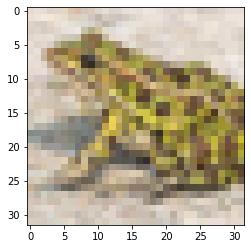

(32, 32, 3)
#$$$$$$$$$$$$$$$$$$$$$$$$$ IN INFER $$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$ in read image $$$$$$$$$$$$$$$$$$$$$$
(32, 32, 3)


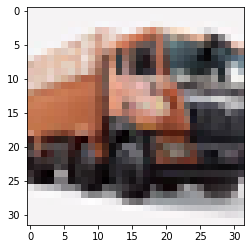

(32, 32, 3)
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f617bfccf90>,
 'http://127.0.0.1:7861/',
 'https://16524.gradio.app')

In [15]:
# gr.Interface(infer, input, output, examples=examples, allow_flagging=False, analytics_enabled=False,
# title=title, description=description).launch(enable_queue=True, debug=True)
gr.Interface(infer, input, output, examples=examples, allow_flagging=False, analytics_enabled=False, title=title, description=description).launch(enable_queue=True, debug=True)